[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NorisTalaban/Data_Fraud_Detection_ml/blob/main/Data_Fraud_Detection.ipynb)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from datetime import datetime
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve
import joblib
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc,
)


In [ ]:
!pip install gdown

# ID sharing file googledrive
file_id = "17cDYSw3MB7C1CLVRMML_BFKlMSICznp3"
!gdown $file_id -O /content/DataFraudCard.csv

DataFraud = pd.read_csv("/content/DataFraudCard.csv")

DataFraud_raw = DataFraud.copy()

print("=== Dataset structure ===")
print(f"Number of rows: {DataFraud.shape[0]}")
print(f"Number of columns: {DataFraud.shape[1]}")
print("\nFirst row:")
print(DataFraud.iloc[0])
print("\n")

print("=== Basic dataset info ===")
print(DataFraud.info())
print("\n=== Missing values per column ===")
print(DataFraud.isnull().sum())
print("\n=== Target variable distribution (is_fraud) ===")
print(DataFraud['is_fraud'].value_counts(normalize=True))

Downloading...
From (original): https://drive.google.com/uc?id=17cDYSw3MB7C1CLVRMML_BFKlMSICznp3
From (redirected): https://drive.google.com/uc?id=17cDYSw3MB7C1CLVRMML_BFKlMSICznp3&confirm=t&uuid=a73d4d1f-dd92-43f9-9064-4a88493e92fe
To: /content/DataFraudCard.csv
100% 208M/208M [00:05<00:00, 39.4MB/s]
=== Dataset structure ===
Number of rows: 1296675
Number of columns: 14

First row:
Unnamed: 0                                              0
trans_date_trans_time                 2019-01-01 00:00:18
cc_num                                   2703186189652095
category                                         misc_net
amt                                                  4.97
gender                                                  F
lat                                               36.0788
long                                             -81.1781
dob                                            1988-03-09
trans_num                0b242abb623afc578575680df30655b9
unix_time                        

In [ ]:


# Processing Base
DataFraud['gender'] = DataFraud['gender'].map({'F': 0, 'M': 1})
DataFraud['dob'] = pd.to_datetime(DataFraud['dob'])
DataFraud['age'] = datetime.now().year - DataFraud['dob'].dt.year
label = LabelEncoder()
DataFraud['category'] = label.fit_transform(DataFraud['category'])

# Distance card holder/merchant
R = 6371
def haversine_vec(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    return R * c

DataFraud['distance_km'] = haversine_vec(
    DataFraud['lat'], DataFraud['long'],
    DataFraud['merch_lat'], DataFraud['merch_long']
)

#feature Time
DataFraud['trans_date_trans_time'] = pd.to_datetime(DataFraud['trans_date_trans_time'])
DataFraud['trans_hour'] = DataFraud['trans_date_trans_time'].dt.hour
DataFraud['trans_weekday'] = DataFraud['trans_date_trans_time'].dt.weekday
DataFraud['trans_date'] = DataFraud['trans_date_trans_time'].dt.date
DataFraud['trans_count_24h'] = DataFraud.groupby(['cc_num', 'trans_date'])['trans_num'].transform('count')


In [ ]:
# Select columns to keep
cols_to_keep = [
    'cc_num', 'amt', 'gender', 'age', 'is_fraud', 'category', 'distance_km',
    'trans_hour', 'trans_weekday', 'trans_count_24h']

DataFraud = DataFraud[cols_to_keep]

print("-"*40)
print("SPLIT TRAIN/TEST")
print("-"*40)

# Separation X feature - y target
X_Container = DataFraud.drop('is_fraud', axis=1)
y_Container = DataFraud['is_fraud']

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_Container, y_Container, test_size=0.3, random_state=421)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")
print(f"Train fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")
print("\n")

----------------------------------------
SPLIT TRAIN/TEST
----------------------------------------
Train size: 907672
Test size: 389003
Train fraud rate: 0.0058
Test fraud rate: 0.0059




In [ ]:
print("-"*60)
print("FEATURE ENGINEERING (calculated only on TRAIN)")
print("-"*60)

# 1. Amount z-score
customer_avg_amt = X_train.groupby('cc_num')['amt'].mean()
customer_std_amt = X_train.groupby('cc_num')['amt'].std()
X_train['amt_z_score'] = (X_train['amt'] - X_train['cc_num'].map(customer_avg_amt)) / X_train['cc_num'].map(customer_std_amt)
X_test['amt_z_score'] = (X_test['amt'] - X_test['cc_num'].map(customer_avg_amt)) / X_test['cc_num'].map(customer_std_amt)
print("amt_z_score created")

# 2. Distance z-score (calculated only on train)
customer_avg_distance = X_train.groupby('cc_num')['distance_km'].mean()
customer_std_distance = X_train.groupby('cc_num')['distance_km'].std()
X_train['distance_z_score'] = (X_train['distance_km'] - X_train['cc_num'].map(customer_avg_distance)) / X_train['cc_num'].map(customer_std_distance)
X_test['distance_z_score'] = (X_test['distance_km'] - X_test['cc_num'].map(customer_avg_distance)) / X_test['cc_num'].map(customer_std_distance)

# 3. Distance ratio to max (only on train)
customer_max_distance = X_train.groupby('cc_num')['distance_km'].max()
X_train['distance_ratio_to_max'] = X_train['distance_km'] / X_train['cc_num'].map(customer_max_distance)
X_test['distance_ratio_to_max'] = X_test['distance_km'] / X_test['cc_num'].map(customer_max_distance)


# 4. Hour deviation
customer_avg_hour = X_train.groupby('cc_num')['trans_hour'].mean()
X_train['hour_deviation'] = abs(X_train['trans_hour'] - X_train['cc_num'].map(customer_avg_hour))
X_test['hour_deviation'] = abs(X_test['trans_hour'] - X_test['cc_num'].map(customer_avg_hour))

# 5. Unusual weekday
customer_mode_weekday = X_train.groupby('cc_num')['trans_weekday'].agg(lambda x: x.mode()[0] if not x.empty else 0)
X_train['unusual_weekday'] = (X_train['trans_weekday'] != X_train['cc_num'].map(customer_mode_weekday)).astype(int)
X_test['unusual_weekday'] = (X_test['trans_weekday'] != X_test['cc_num'].map(customer_mode_weekday)).astype(int)


# 6. Unusual category
customer_top_category = X_train.groupby('cc_num')['category'].agg(lambda x: x.mode()[0] if not x.empty else 0)
X_train['unusual_category'] = (X_train['category'] != X_train['cc_num'].map(customer_top_category)).astype(int)
X_test['unusual_category'] = (X_test['category'] != X_test['cc_num'].map(customer_top_category)).astype(int)
print("unusual_category created")

# Handle missing values and infinites
X_train['amt_z_score'] = X_train['amt_z_score'].fillna(0).replace([np.inf, -np.inf], [10, -10])
X_test['amt_z_score'] = X_test['amt_z_score'].fillna(0).replace([np.inf, -np.inf], [10, -10])
X_train['distance_z_score'] = X_train['distance_z_score'].fillna(0)
X_test['distance_z_score'] = X_test['distance_z_score'].fillna(0)
X_train['distance_ratio_to_max'] = X_train['distance_ratio_to_max'].fillna(1.0)
X_test['distance_ratio_to_max'] = X_test['distance_ratio_to_max'].fillna(1.0)
print("Missing values handled")

# Remove cc_num and amt (not needed anymore)
X_train = X_train.drop(['cc_num', 'amt'], axis=1)
X_test = X_test.drop(['cc_num', 'amt'], axis=1)
print("cc_num and amt removed")

print(f"\nFinal feature count: {X_train.shape[1]}")
print(f"Features: {list(X_train.columns)}")
print("\n")

------------------------------------------------------------
FEATURE ENGINEERING (calculated only on TRAIN)
------------------------------------------------------------
amt_z_score created
unusual_category created
Missing values handled
cc_num and amt removed

Final feature count: 13
Features: ['gender', 'age', 'category', 'distance_km', 'trans_hour', 'trans_weekday', 'trans_count_24h', 'amt_z_score', 'distance_z_score', 'distance_ratio_to_max', 'hour_deviation', 'unusual_weekday', 'unusual_category']




In [ ]:
print("-"*10)
print("SCALING")
print("-"*10)

features_to_scale = ['distance_km', 'trans_count_24h', 'amt_z_score','distance_z_score', 'hour_deviation']

scaler = StandardScaler()
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

print("Features scaled")
print(f"Scaled features: {features_to_scale}")
print("\n")

print("-"*40)
print("SMOTE")
print("-"*40)

print("Distribution before SMOTE:")
print(f"  Class 0: {np.bincount(y_train)[0]}")
print(f"  Class 1: {np.bincount(y_train)[1]}")

smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("Distribution after SMOTE:")
print(f"  Class 0: {np.bincount(y_train)[0]}")
print(f"  Class 1: {np.bincount(y_train)[1]}")
print("\n")


----------
SCALING
----------
Features scaled
Scaled features: ['distance_km', 'trans_count_24h', 'amt_z_score', 'distance_z_score', 'hour_deviation']


----------------------------------------
SMOTE
----------------------------------------
Distribution before SMOTE:
  Class 0: 902450
  Class 1: 5222
Distribution after SMOTE:
  Class 0: 902450
  Class 1: 270735




In [ ]:
print("-"*40)
print("MODEL TRAINING")
print("-"*40)

model = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    eval_metric='logloss',
    verbosity=1,
    random_state=42,
    max_depth=7,
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    min_child_weight=1,
    reg_alpha=0,
    reg_lambda=1
)

print("Training XGBoost model...")
model.fit(X_train, y_train)
print("Training completed\n")


----------------------------------------
MODEL TRAINING
----------------------------------------
Training XGBoost model...
Training completed



In [ ]:
print("-"*40)
print("PREDICTIONS")
print("-"*40)

# Probability
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_train_proba = model.predict_proba(X_train)[:, 1]

#Personalized Threshold
user_threshold = 0.9
threshold = user_threshold or 0.5  #if choose None value is 0.5

y_pred = (y_pred_proba >= threshold).astype(int)
y_train_pred = (y_train_proba >= threshold).astype(int)

print("Predictions completed\n")

print("-"*40)
print("METRICS")
print("-"*40)

# AUC
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nAUC Scores:")
print(f"  Train AUC: {train_auc:.4f}")
print(f"  Test AUC:  {test_auc:.4f}")

# Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy:")
print(f"  Train: {train_accuracy:.4f}")
print(f"  Test:  {test_accuracy:.4f}")

# F1-Score
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"\nF1-Score:")
print(f"  Train: {train_f1:.4f}")
print(f"  Test:  {test_f1:.4f}")

# Detailed metrics per class - Test Set
precision_0 = precision_score(y_test, y_pred, pos_label=0)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
f1_0 = f1_score(y_test, y_pred, pos_label=0)

precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_1 = recall_score(y_test, y_pred, pos_label=1)
f1_1 = f1_score(y_test, y_pred, pos_label=1)

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

metrics_table = pd.DataFrame({
    'Precision': [precision_0, precision_1, precision_macro, precision_weighted],
    'Recall': [recall_0, recall_1, recall_macro, recall_weighted],
    'F1-Score': [f1_0, f1_1, f1_macro, f1_weighted]
}, index=['Class 0 (Non-Fraud)', 'Class 1 (Fraud)', 'Macro Avg', 'Weighted Avg'])

print("\n--- Detailed Classification Metrics (Test Set) ---")
print(metrics_table.to_string())

print("\n--- GAP Performance Train vs Test ---")
print(f"Accuracy Gap: {train_accuracy - test_accuracy:.4f}")
print(f"F1-Score Gap: {train_f1 - test_f1:.4f}")
print(f"AUC Gap:      {train_auc - test_auc:.4f}")




----------------------------------------
PREDICTIONS
----------------------------------------


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [11:49:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Predictions completed

----------------------------------------
METRICS
----------------------------------------

AUC Scores:
  Train AUC: 0.9999
  Test AUC:  0.9919

Accuracy:
  Train: 0.9913
  Test:  0.9980

F1-Score:
  Train: 0.9808
  Test:  0.7955

--- Detailed Classification Metrics (Test Set) ---
                     Precision    Recall  F1-Score
Class 0 (Non-Fraud)   0.998090  0.999860  0.998974
Class 1 (Fraud)       0.966208  0.676007  0.795466
Macro Avg             0.982149  0.837934  0.897220
Weighted Avg          0.997903  0.997959  0.997779

--- GAP Performance Train vs Test ---
Accuracy Gap: -0.0067
F1-Score Gap: 0.1853
AUC Gap:      0.0080



--- Confusion Matrix (Test Set) ---
                Predicted
              Non-Fraud  Fraud
Actual Non-Fraud  386665      54
       Fraud         740    1544

------------------------------------------------------------
COMPLETED
------------------------------------------------------------


<Figure size 600x600 with 0 Axes>

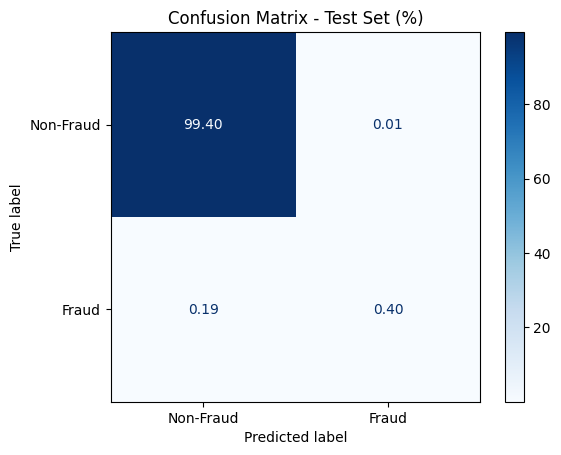

In [ ]:

cm = confusion_matrix(y_test, y_pred)
print("\n--- Confusion Matrix (Test Set) ---")
print("                Predicted")
print("              Non-Fraud  Fraud")
print(f"Actual Non-Fraud  {cm[0][0]:6d}  {cm[0][1]:6d}")
print(f"       Fraud      {cm[1][0]:6d}  {cm[1][1]:6d}")

print("\n" + "-"*60)
print("COMPLETED")
print("-"*60)

cm_percent = cm.astype('float') / cm.sum() * 100

# Plot
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Confusion Matrix - Test Set (%)')
plt.show()

In [ ]:

thresholds = [0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]

threshold_results = []

for t in thresholds:
    y_pred_t = (y_pred_proba >= t).astype(int)


    threshold_results.append({
        'Threshold': t,
        'Precision_0': precision_score(y_test, y_pred_t, pos_label=0),
        'Recall_0': recall_score(y_test, y_pred_t, pos_label=0),
        'F1_0': f1_score(y_test, y_pred_t, pos_label=0),
        'Precision_1': precision_score(y_test, y_pred_t, pos_label=1),
        'Recall_1': recall_score(y_test, y_pred_t, pos_label=1),
        'F1_1': f1_score(y_test, y_pred_t, pos_label=1),
        'Precision_Macro': precision_score(y_test, y_pred_t, average='macro'),
        'Recall_Macro': recall_score(y_test, y_pred_t, average='macro'),
        'F1_Macro': f1_score(y_test, y_pred_t, average='macro'),
        'Precision_Weighted': precision_score(y_test, y_pred_t, average='weighted'),
        'Recall_Weighted': recall_score(y_test, y_pred_t, average='weighted'),
        'F1_Weighted': f1_score(y_test, y_pred_t, average='weighted'),
    })

threshold_results_df = pd.DataFrame(threshold_results)
threshold_results_df

,Threshold,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Precision_Macro,Recall_Macro,F1_Macro,Precision_Weighted,Recall_Weighted,F1_Weighted
0,0.2,0.999180,0.995278,0.997225,0.518714,0.861646,0.647581,0.758947,0.928462,0.822403,0.996359,0.994494,0.995172
1,0.3,0.999075,0.997324,0.998199,0.650574,0.843695,0.734655,0.824825,0.920509,0.866427,0.997029,0.996422,0.996651
2,0.5,0.998818,0.998870,0.998844,0.806979,0.799912,0.803430,0.902899,0.899391,0.901137,0.997692,0.997702,0.997697
3,0.6,0.998703,0.999222,0.998962,0.855497,0.780210,0.816121,0.927100,0.889716,0.907541,0.997862,0.997936,0.997889
4,0.7,0.998556,0.999506,0.999031,0.900313,0.755254,0.821429,0.949435,0.877380,0.910230,0.997979,0.998072,0.997988
5,0.8,0.998360,0.999705,0.999032,0.935337,0.721979,0.814925,0.966849,0.860842,0.906978,0.997990,0.998075,0.997951
6,0.9,0.998090,0.999860,0.998974,0.966208,0.676007,0.795466,0.982149,0.837934,0.897220,0.997903,0.997959,0.997779


----------------------------------------
Learning Curve
----------------------------------------


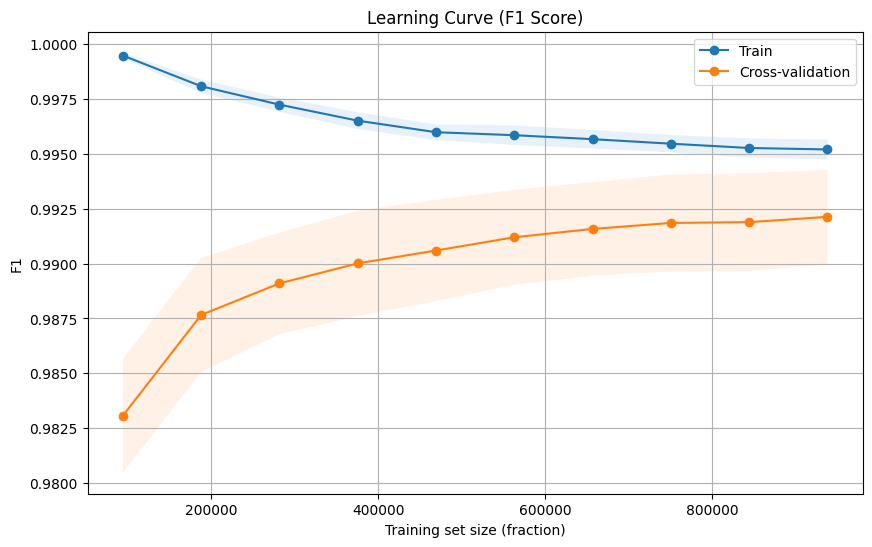

In [ ]:
print("-"*40)
print("Learning Curve")
print("-"*40)


scoring_metric = 'f1'

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring=scoring_metric,
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

#mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Train')
plt.plot(train_sizes, test_mean, 'o-', label='Cross-validation')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training set size (fraction)')
plt.ylabel(scoring_metric.upper())
plt.title(f'Learning Curve ({scoring_metric.upper()} Score)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


VALIDATION CURVE - MAX_DEPTH


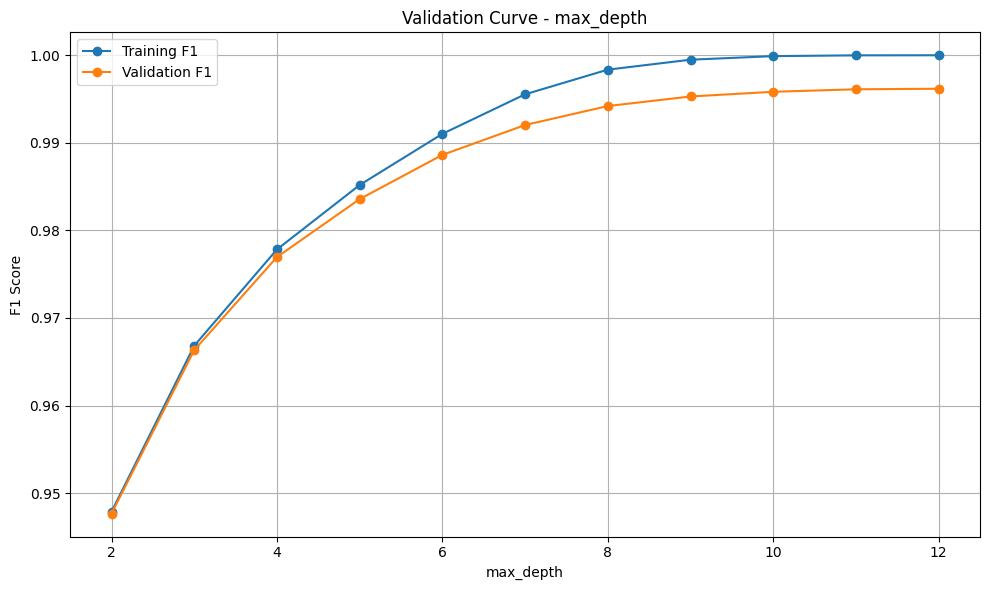

Optimal max_depth based on Validation F1: 12
Training F1 at this depth: 1.0000
Validation F1 at this depth: 0.9962


In [ ]:
print("="*60)
print("VALIDATION CURVE - MAX_DEPTH")
print("="*60)

param_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

train_scores, test_scores = validation_curve(
    xgb.XGBClassifier(
        tree_method='hist',
        device='cuda',
        eval_metric='logloss',
        random_state=42,
        n_estimators=1000,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8
    ),
    X_train,
    y_train,
    param_name='max_depth',
    param_range=param_range,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# Compute mean scores
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores_mean, marker='o', label='Training F1')
plt.plot(param_range, test_scores_mean, marker='o', label='Validation F1')
plt.title('Validation Curve - max_depth')
plt.xlabel('max_depth')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#Optimal max depth
best_index = np.argmax(test_scores_mean)
best_max_depth = param_range[best_index]
print(f"Optimal max_depth based on Validation F1: {best_max_depth}")
print(f"Training F1 at this depth: {train_scores_mean[best_index]:.4f}")
print(f"Validation F1 at this depth: {test_scores_mean[best_index]:.4f}")


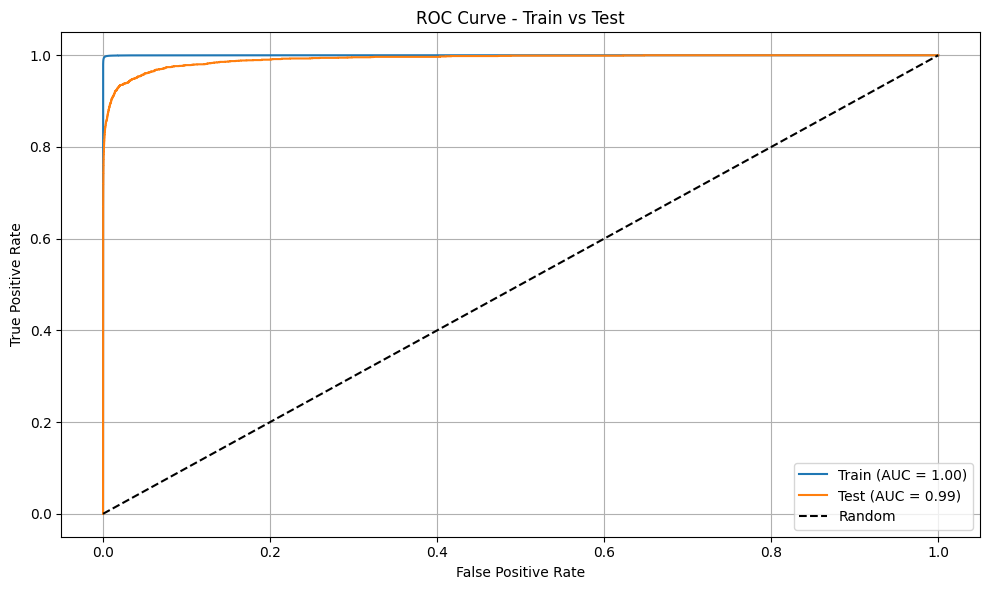

In [ ]:
# Plot ROC train vs test
def plot_roc_curve(y_true, y_score, dataset_label):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{dataset_label} (AUC = {roc_auc:.2f})')

y_train_proba = model.predict_proba(X_train)[:, 1]

plt.figure(figsize=(10, 6))
plot_roc_curve(y_train, y_train_proba, 'Train')
plot_roc_curve(y_test, y_pred_proba, 'Test')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve - Train vs Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

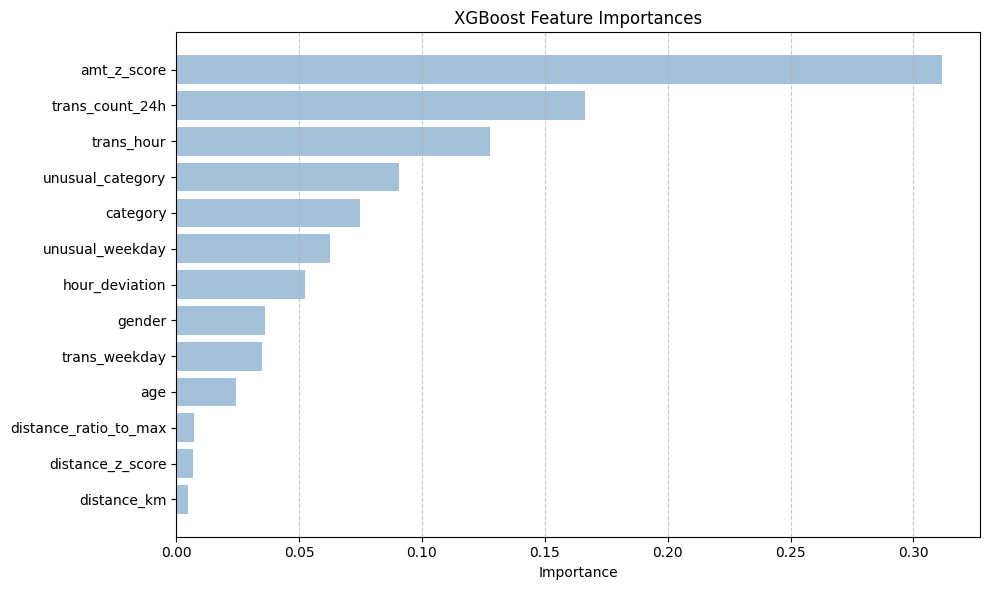

Model saved as 'xgb_fraud_model.pkl'


In [ ]:
# --- Feature Importance ---
importances = model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#A3C1DA')
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Save the trained model ---
model_filename = 'xgb_fraud_model.pkl'
joblib.dump(model, model_filename)
print(f"Model saved as '{model_filename}'")


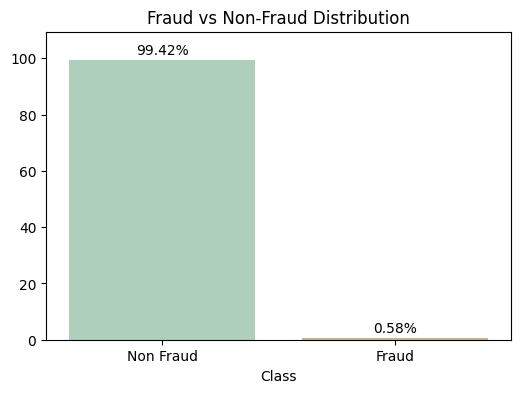

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


fraud_percent = y_Container.value_counts(normalize=True) * 100
df = pd.DataFrame({
    'Class': ['Non Fraud', 'Fraud'],
    'Percentage': fraud_percent.values
})

plt.figure(figsize=(6,4))
palette = ['#A8D5BA', '#D2B48C']

ax = sns.barplot(
    data=df,
    x='Class',
    y='Percentage',
    hue='Class',
    palette=palette,
    dodge=False,
    legend=False
)

plt.ylabel('')
plt.title('Fraud vs Non-Fraud Distribution')


for i, value in enumerate(df['Percentage']):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', va='bottom', color='black', fontsize=10)

plt.ylim(0, max(df['Percentage']) + 10)
plt.show()


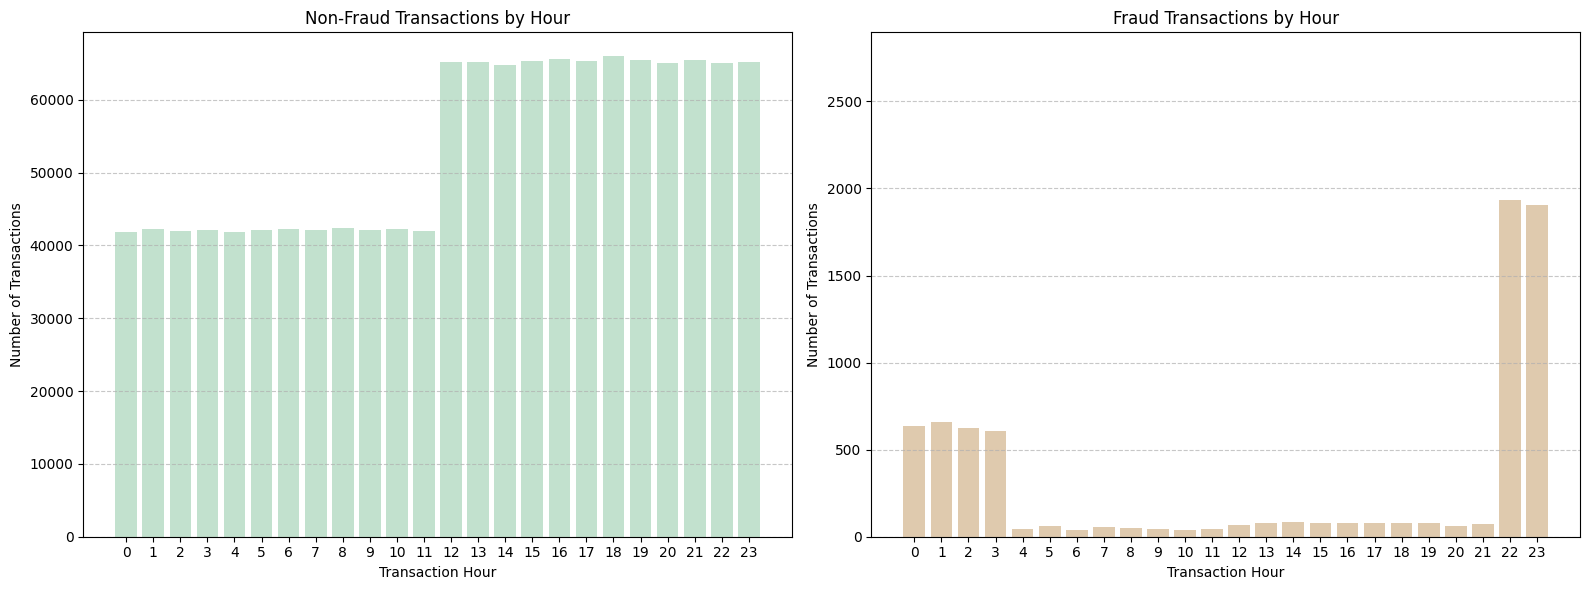

In [ ]:

visual_fraud = DataFraud[DataFraud['is_fraud'] == 1]
visual_fraud_hour = visual_fraud['trans_hour'].value_counts().sort_index()
visual_nonfraud = DataFraud[DataFraud['is_fraud'] == 0]
visual_nonfraud_hour = visual_nonfraud['trans_hour'].value_counts().sort_index()

visual_all_hours = list(range(24))
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=True)

# Plot Non-Fraud
axes[0].bar(visual_nonfraud_hour.index, visual_nonfraud_hour.values, color='#A8D5BA', alpha=0.7)
axes[0].set_title('Non-Fraud Transactions by Hour')
axes[0].set_xlabel('Transaction Hour')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_xticks(visual_all_hours)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Fraud
axes[1].bar(visual_fraud_hour.index, visual_fraud_hour.values, color='#D2B48C', alpha=0.7)
axes[1].set_title('Fraud Transactions by Hour')
axes[1].set_xlabel('Transaction Hour')
axes[1].set_ylabel('Number of Transactions')
axes[1].set_xticks(visual_all_hours)
axes[1].set_ylim(0, visual_fraud_hour.max() * 1.5)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


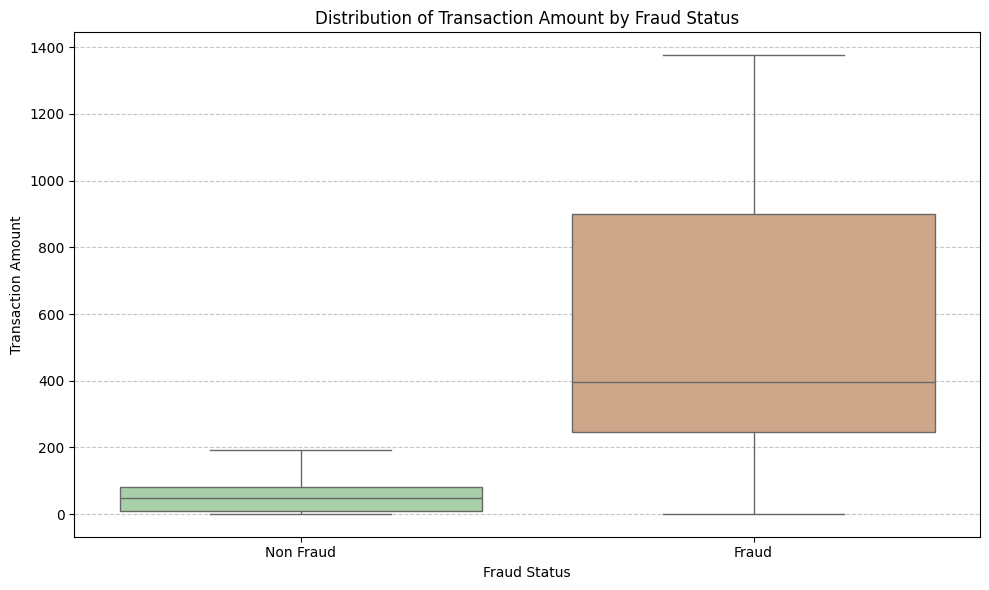

In [ ]:
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
visual_amount = DataFraud[['is_fraud', 'amt']].copy()
visual_amount['fraud_label'] = visual_amount['is_fraud'].map({0: 'Non Fraud', 1: 'Fraud'})


colors = ['#A3D5A3', '#D9A57F']
plt.figure(figsize=(10, 6))

sns.boxplot(
    x='fraud_label',
    y='amt',
    data=visual_amount,
    hue='fraud_label',
    palette=colors,
    showfliers=False,
    dodge=False
)

plt.title('Distribution of Transaction Amount by Fraud Status')
plt.xlabel('Fraud Status')
plt.ylabel('Transaction Amount')


plt.legend([],[], frameon=False)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0f}'))

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


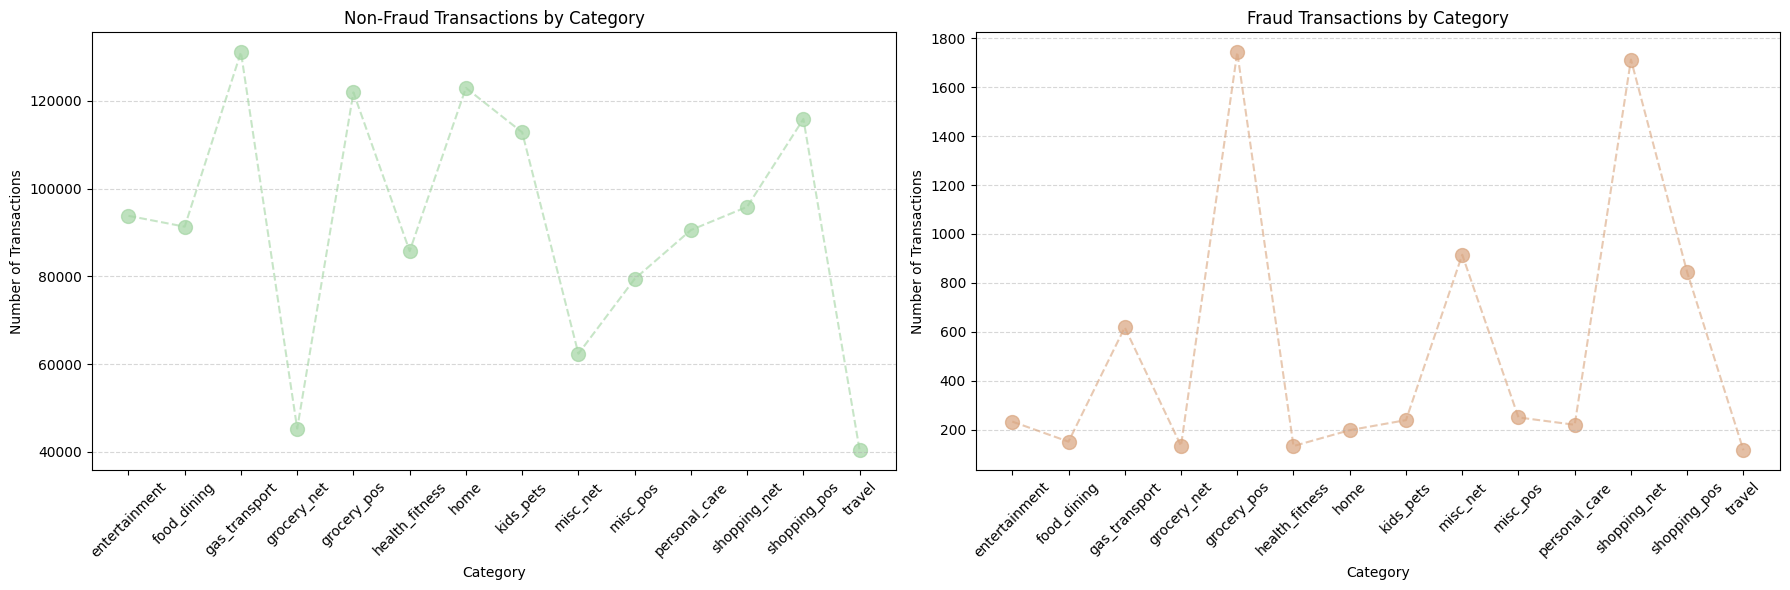

In [ ]:
category_count = DataFraud_raw.groupby(['category', 'is_fraud']).size().reset_index(name='count')


non_fraud = category_count[category_count['is_fraud']==0].sort_values(by='category')
fraud = category_count[category_count['is_fraud']==1].sort_values(by='category')

fig, axes = plt.subplots(1, 2, figsize=(18,6), sharex=False)

# Non-Fraud plot
axes[0].scatter(
    non_fraud['category'],
    non_fraud['count'],
    s=100,
    color='#A3D5A3',
    alpha=0.7,
    label='Non-Fraud'
)
axes[0].plot(
    non_fraud['category'],
    non_fraud['count'],
    color='#A3D5A3',
    linestyle='--',
    alpha=0.6
)
axes[0].set_title("Non-Fraud Transactions by Category")
axes[0].set_ylabel("Number of Transactions")
axes[0].set_xlabel("Category")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Fraud plot
axes[1].scatter(
    fraud['category'],
    fraud['count'],
    s=100,
    color='#D9A57F',
    alpha=0.7,
    label='Fraud'
)
axes[1].plot(
    fraud['category'],
    fraud['count'],
    color='#D9A57F',
    linestyle='--',
    alpha=0.6
)
axes[1].set_title("Fraud Transactions by Category")
axes[1].set_ylabel("Number of Transactions")
axes[1].set_xlabel("Category")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


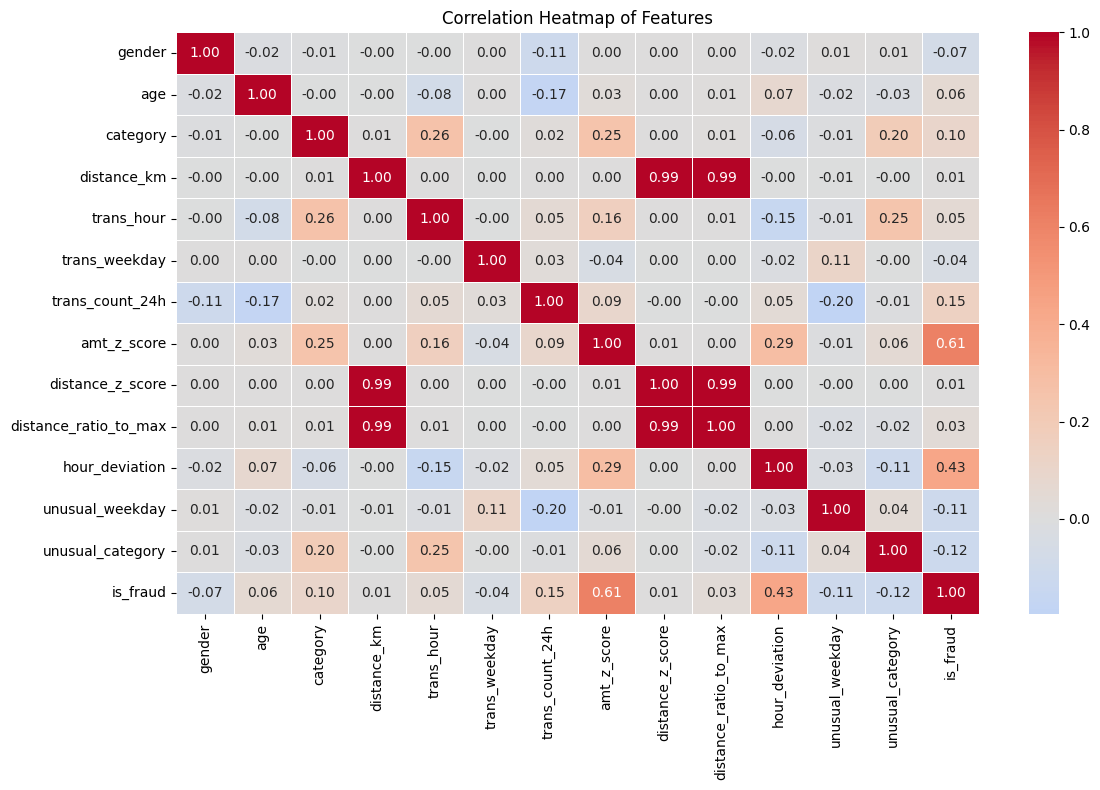

In [ ]:
corr_matrix = X_train.copy()
corr_matrix['is_fraud'] = y_train
corr = corr_matrix.corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()
